## Пример загрузки данных
### Импортируем библиотеки для загрузки данных

In [42]:
from astropy.io import ascii
from astroquery.gaia import Gaia


### Загружаем данные
Запрос взят из статьи 

In [43]:
query = f"SELECT phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr2.gaia_source\
        WHERE parallax_over_error > 10\
        AND phot_g_mean_flux_over_error>50\
        AND phot_rp_mean_flux_over_error>20\
        AND phot_bp_mean_flux_over_error>20\
        AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)\
        AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)\
        AND visibility_periods_used>8\
        AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"

job     = Gaia.launch_job_async(query)
results = job.get_results()
print(f'Table size (rows): {len(results)}')
#3000000????

ascii.write(results, 'results.dat', overwrite=True)

KeyboardInterrupt: 

### Запрос для подсчета кол-ва строк в результате запроса 

In [ ]:
query = f"SELECT COUNT(bp_rp) FROM gaiadr2.gaia_source\
        WHERE parallax_over_error > 10\
        AND phot_g_mean_flux_over_error>50\
        AND phot_rp_mean_flux_over_error>20\
        AND phot_bp_mean_flux_over_error>20\
        AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)\
        AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)\
        AND visibility_periods_used>8\
        AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"
job     = Gaia.launch_job_async(query)
results = job.get_results()
print(results)

#65921112


INFO: Query finished. [astroquery.utils.tap.core]
 COUNT  
--------
65921112


Должно возврщаться 65кк, а возвращается только 3кк

## Визуализация
### Загружаем pyplot

In [ ]:
import matplotlib.pyplot as plt

### Просто нарисуем результат как множество точек

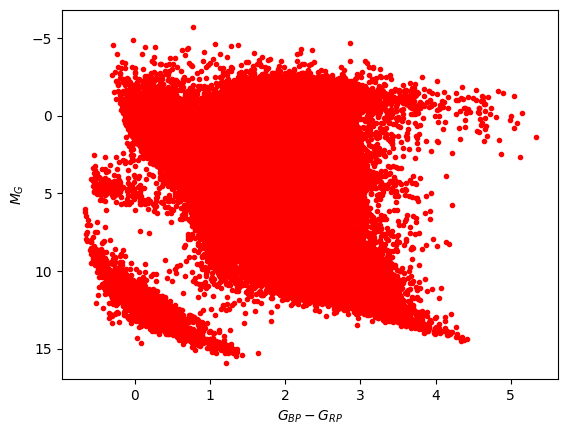

In [ ]:
results = ascii.read("results.dat") 

fig, ax = plt.subplots()
ax.invert_yaxis()
ax.set_xlabel(r'$G_{BP}-G_{RP}$')
ax.set_ylabel(r'$M_{G}$')

ax.plot(results['bp_rp'], results['mg'], 'r.')
plt.show()

### Загружаем библиотеки для более красивой визуализации

In [ ]:
from scipy.stats import gaussian_kde
import numpy as np
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import PowerStretch

### Первый метод
***ОЧЕНЬ МЕДЛЕННЫЙ!***

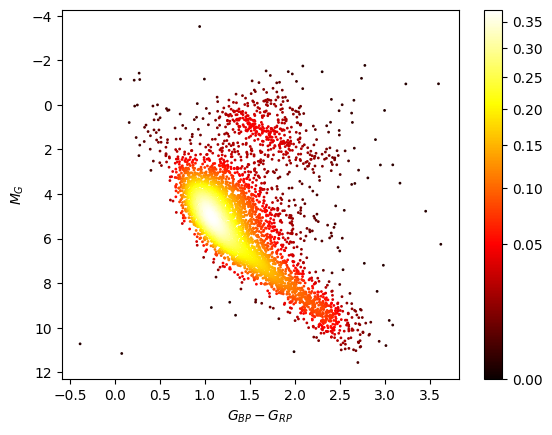

In [ ]:
#very slow

x = results['bp_rp']
y = results['mg']   

norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.5))

# fit an array of size [Ndim, Nsamples]
data = np.vstack([x, y])
z = gaussian_kde(data)(data)

idx = z.argsort()                                                  
x2, y2, z = x[idx], y[idx], z[idx]  

fig, ax = plt.subplots()

ax.invert_yaxis()
ax.set_xlabel(r'$G_{BP}-G_{RP}$')
ax.set_ylabel(r'$M_{G}$')

s = ax.scatter(                                                     
    x2, y2, c=z, s=1, norm=norm, cmap='hot', label=None, picker=True, zorder=2                
)
plt.colorbar(s)
plt.show()

### Второй метод

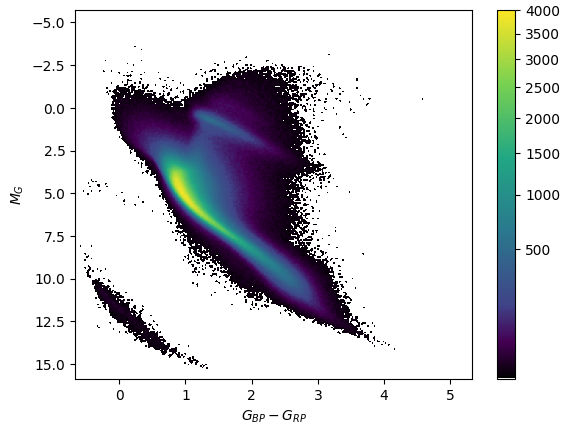

In [153]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#000000'),
    (0.1, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

norm = ImageNormalize(vmin=1, stretch=PowerStretch(0.5))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
ax.set_xlabel(r'$G_{BP}-G_{RP}$')
ax.set_ylabel(r'$M_{G}$')
density = ax.scatter_density(x, y, cmap=white_viridis, norm=norm)
ax.invert_yaxis()
fig.colorbar(density, label='')
plt.show()

## Загрузка данных из третьего релиза

Обрабатывает по 1% за запрос, чтобы решить проблему с ограничениями

In [33]:
for i in range(100):
    query = f"SELECT phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr3.gaia_source\
        WHERE parallax_over_error > 10\
        AND random_index BETWEEN " + str(i) + " * 0.01 * 1811709771 AND " + str(i + 1) + " * 0.01 * 1811709771 - 1\
        AND phot_g_mean_flux_over_error > 50\
        AND phot_rp_mean_flux_over_error > 20\
        AND phot_bp_mean_flux_over_error > 20\
        AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)\
        AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)\
        AND visibility_periods_used > 8\
        AND astrometric_chi2_al/(astrometric_n_good_obs_al-5) < 1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"

    job     = Gaia.launch_job_async(query)
    results = job.get_results()
    print(i)
    print(f'Table size (rows): {len(results)}')

    filename = 'result/result_3_' + str(i)
    ascii.write(results, filename, overwrite=True)

INFO: Query finished. [astroquery.utils.tap.core]
0
Table size (rows): 912797
INFO: Query finished. [astroquery.utils.tap.core]
1
Table size (rows): 913808
INFO: Query finished. [astroquery.utils.tap.core]
2
Table size (rows): 913289
INFO: Query finished. [astroquery.utils.tap.core]
3
Table size (rows): 913998
INFO: Query finished. [astroquery.utils.tap.core]
4
Table size (rows): 913025
INFO: Query finished. [astroquery.utils.tap.core]
5
Table size (rows): 912602
INFO: Query finished. [astroquery.utils.tap.core]
6
Table size (rows): 913018
INFO: Query finished. [astroquery.utils.tap.core]
7
Table size (rows): 914112
INFO: Query finished. [astroquery.utils.tap.core]
8
Table size (rows): 913490
INFO: Query finished. [astroquery.utils.tap.core]
9
Table size (rows): 914781


RemoteDisconnected: Remote end closed connection without response

## Визуализация
Используется второй метод

0
1
2
3
4
5
6
7
8
9


d:\My programs\big data\Course5\test-data-loader\.venv\lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
d:\My programs\big data\Course5\test-data-loader\.venv\lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


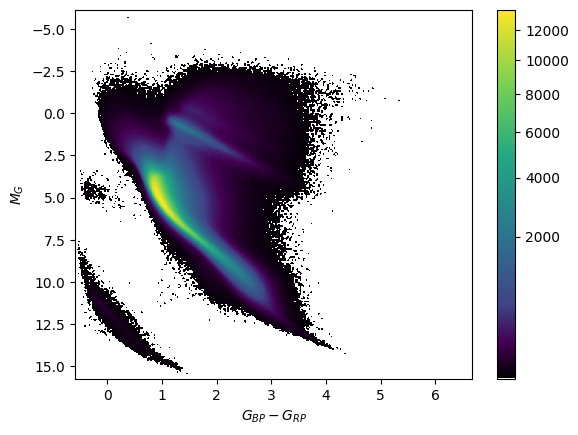

In [41]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#000000'),
    (0.1, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

norm = ImageNormalize(vmin=1, stretch=PowerStretch(0.5))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
ax.set_xlabel(r'$G_{BP}-G_{RP}$')
ax.set_ylabel(r'$M_{G}$')

X, Y = [], []

for i in range(10):
    print(i)
    filename = 'result/result_3_' + str(i) 
    results = ascii.read(filename)
    x = results['bp_rp']
    y = results['mg']
    X = np.hstack((X, x))
    Y = np.hstack((Y, y))

density = ax.scatter_density(X, Y, cmap=white_viridis, norm=norm)
ax.invert_yaxis()
fig.colorbar(density, label='')
plt.show()